# Checking the SEO Test Setup

I.e. checking that the right urls are set up, without going too crazy on testing everything.

In brief:

* Focus on the articles
* Check the test urls are accessible and show v2
* If AMP is enabled, test that control urls show v1 AMP and test urls show v2
* Check the canonicals
* Check the breadcrumbs
* That cloudflare looks to be working


Out of scope:

* That an AMP page is valid AMP (we have a separate test suite for this)
* Being robust to html that isn't what's expected during blog v2 launch!
* Testing non-article pages (home page, category page etc)

In [1]:
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import csv
import json
import urllib
import json
import time
import matplotlib.pyplot as plt
from random import random, randint
import numpy as np

## Settings


In [2]:
country_to_test = "hk"
test_staging = False

In [3]:


test_urls_csv_filepath = {  # These originally come from https://docs.google.com/spreadsheets/d/1UdrncwVdObaA6d0lnvbAQCHBpQMzEhWPz5OTR9Syobo/edit#gid=0
    "id":"./SEO Test Urls/id_seo_test_urls.csv",
    "tw":"./SEO Test Urls/tw_seo_test_urls.csv",
    "sg": "./SEO Test Urls/sg_seo_test_urls.csv",
    "hk": "./SEO Test Urls/hk_seo_test_urls.csv",
}

production_staging_urls = {
    "id": ["https://www.moneysmart.id", "https://www.msiddev.com"],
    "tw":["https://www.moneysmart.tw", "https://www.mstwdev.com"],
    "sg": ["https://blog.moneysmart.sg","https://blog.mssgdev.com"],
    "hk":["https://blog.moneysmart.hk", "https://blog.mshkdev.com"],
}

def get_site_canonical_url():
    
    return production_staging_urls[country_to_test][(1 if test_staging else 0)]

post_sitemaps = { #yes, we could load some more dynamically but it saves some coding
    "id": ["https://www.moneysmart.id/post-sitemap%i.xml"%i for i in range(1,13)],
    "tw": ["https://www.moneysmart.tw/post-sitemap.xml"],
    "sg": ["https://blog.moneysmart.sg/post-sitemap%i.xml"%i for i in range(1,5)],
    "hk": ["https://blog.moneysmart.hk/post-sitemap%i.xml"%i for i in range(1,3)],
    
    #Aside, there seems to be public pages for the ads in the sitemap :( 
    
}

# RSS feed requests are taken from scalyr by setting display to show uri, remote_ip, status
# e.g. https://www.scalyr.com/events?filter=%22%2Ffeed%2F%22%20$status%3D200&teamToken=RsXhT5US%2FMZ7ugkOhT2g3g--&logSource=*blog-moneysmart-sg-*&showSystemPrefs=%5B%22timestamp%22%5D&showAdditionalFields=%5B%22uri%22,%22remote_ip%22,%22status%22%5D&startTime=7%20days&displayMode=%5Bobject%20Object%5D
rss_feed_scalyr_requests_raw = {
    "id":"./RSS Feed Urls/id_scalyr_feed_requests_tidy.txt",
    "tw":"./RSS Feed Urls/tw_scalyr_feed_requests_tidy.txt",
    "sg": "./RSS Feed Urls/sg_scalyr_feed_requests_tidy.txt",
    "hk": "./RSS Feed Urls/hk_scalyr_feed_requests_tidy.txt",
    
}


#Redirects

#These are taken from Yoast.  You can go to yoast-> tools -> import and export to get a CSV of redirects.
#https://admin.mstwdev.com/wp-admin/admin.php?page=wpseo_tools&tool=import-export#top#export-redirects
#You could do a database query to a copy of production in future.

staging_redirects_csvs = {
    "id":"./Redirects/id-staging-redirects.csv",
    "tw":"./Redirects/tw-staging-redirects.csv",
    "sg":"./Redirects/sg-staging-redirects.csv",
    "hk":"./Redirects/hk-staging-redirects.csv",
    
}

production_redirects_csvs = {
    "id":"./Redirects/id-production-redirects.csv",
    "tw":"./Redirects/tw-production-redirects.csv",
    "sg":"./Redirects/sg-production-redirects.csv",
    "hk": "./Redirects/hk-production-redirects.csv",
    
}

#These passwords aren't sensitive, they're just there to block search engine.
v1_staging_passwords = {
    "id":["admin", "moneysmart"],
    "tw":["admin", "Bubbl3"],
    "sg":["admin", "duri@n"],
    "hk":["admin", "yu3ch@"],
}

v2_staging_passwords = {
    "id":["admin", "moneysmart"],
    "tw":["admin", "moneysmart"],
    "sg":["admin", "moneysmart"],
    "hk":["admin", "moneysmart"],
}

amp_is_enabled = {
    "id":True,
    "tw":False,
    "sg":False,
    "hk":False,
    
}

## Test URL Sets

In [4]:
def load_seo_test_urls(country_code):
    filepath = test_urls_csv_filepath[country_code]
    urls = []
    with open(filepath) as f:
        csv_reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(csv_reader):
            if i==0:
                print("Skipping first line of url file: %s"%row)
                continue
            urls.append(row[0].strip())

    return urls

seo_test_urls = load_seo_test_urls(country_to_test)

print("Found %i test urls to check for" % len(seo_test_urls))


Skipping first line of url file: ['url']
Found 50 test urls to check for


In [5]:
for a in seo_test_urls:print(a)

https://blog.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/
https://blog.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/
https://blog.moneysmart.hk/zh-hk/travel/金巴-直通巴士-澳門船票-港珠澳大橋/
https://blog.moneysmart.hk/zh-hk/budgeting/迷你倉-價錢-收費-比較/
https://blog.moneysmart.hk/zh-hk/mortgage/綠置居-揀樓-麗翠苑-長沙灣-文件-入伙/
https://blog.moneysmart.hk/zh-hk/budgeting/返工-慳車費-九巴-港鐵-乘車-轉乘優惠-全月通-都會票/
https://blog.moneysmart.hk/zh-hk/budgeting/迪士尼-年票-奇妙處處通-優惠/
https://blog.moneysmart.hk/zh-hk/budgeting/小童免費-暑假-旅行-機鐵-機場快綫-優惠-klook-kkday/
https://blog.moneysmart.hk/zh-hk/budgeting/2018大學電腦優惠-時間表-poly-ou-city-港大-中大-科大/
https://blog.moneysmart.hk/zh-hk/credit-cards/恒生-信用卡-現金回贈-最划算/
https://blog.moneysmart.hk/zh-hk/mortgage/按揭-h按-p按-hibor-加息-銀行-封頂位/
https://blog.moneysmart.hk/zh-hk/mortgage/綠表白表資格-居屋-綠置居-入息-家庭-2019/
https://blog.moneysmart.hk/zh-hk/travel/行李費-日本-廉航-窮遊-攻略-寄艙-行李-限重/
https://blog.moneysmart.hk/zh-hk/budgeting/2020日本東京奧運門票-價錢-購買-官網/
https://blog.moneysmart.hk/zh-hk/credit-cards

## Check SEO Test URLs aren't Redirects

Redirects implies that we won't be able to get sensible results from search console as they should have dropped off already to the redirected-to url.

In [6]:
def load_redirects(country_code, for_staging, unencode_urls = False):
    """
    Returns [from_url, to_url, redirect_code]
    Where from_url is the full url (and the source CSV doesn't state as full url)
    
    Use unencode_urls for TW and HK
    """
    print("cow")
    base_url = production_staging_urls[country_code][1 if for_staging else 0]
    redirects_csv_path = None
    if for_staging:
        redirects_csv_path = staging_redirects_csvs[country_code]
    else:
        redirects_csv_path = production_redirects_csvs[country_code]

    print("Loading all of the redirects from %s" % redirects_csv_path)

    redirects = [] #from, to, code
    with open(redirects_csv_path) as f: #Origin,Target,Type,Format
        csv_reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(csv_reader):
            if i==0:
                print("Skipping first line of url file: %s"%row)
                continue
            from_url, to_url, redirect_code, redirect_format = row
            if unencode_urls:
                #TODO: not sure how safe this is unquoting, but doing to try to match TW urls.
                from_url = urllib.parse.unquote(from_url)
                to_url = urllib.parse.unquote(to_url)
            from_url_full = urllib.parse.urljoin(base_url, from_url)+"/"
            to_url_full = urllib.parse.urljoin(base_url, to_url)+"/"
            redirects.append([from_url_full, to_url_full, redirect_code])

    print("Loaded %i redirects"% len(redirects))
    return redirects

In [7]:
# Get the production redirects as at this point we're testing the production urls 
# (there might be a mismatch with staging, but this is the safest test)

production_redirects = load_redirects(country_to_test, for_staging=False, unencode_urls = True)

cow
Loading all of the redirects from ./Redirects/hk-production-redirects.csv
Skipping first line of url file: ['Origin', 'Target', 'Type', 'Format']
Loaded 3 redirects


In [8]:
production_redirected_urls = [z[0] for z in production_redirects]
seo_test_urls_that_are_redirects = [z for z in seo_test_urls if z in production_redirected_urls]

In [9]:
# Check the below two blocks look similar / the urls are likely to match

In [10]:
production_redirected_urls[:5]

['https://blog.moneysmart.hk/zh-hk/credit-cards/飛行里數-信用卡-比較-2018/',
 'https://blog.moneysmart.hk/zh-hk/budgeting/嘉頓什餅-拜年-送禮-農曆新年-網購-hktvmall/',
 'https://blog.moneysmart.hk/']

In [11]:
seo_test_urls[:5]

['https://blog.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/',
 'https://blog.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/',
 'https://blog.moneysmart.hk/zh-hk/travel/金巴-直通巴士-澳門船票-港珠澳大橋/',
 'https://blog.moneysmart.hk/zh-hk/budgeting/迷你倉-價錢-收費-比較/',
 'https://blog.moneysmart.hk/zh-hk/mortgage/綠置居-揀樓-麗翠苑-長沙灣-文件-入伙/']

In [12]:
if len(seo_test_urls_that_are_redirects)>0:
    print("The following SEO test urls were redirects.  We should remove them from the test:")
    for a in seo_test_urls_that_are_redirects:
        print(a)
    
else:
    print("Looks like none of the SEO test urls are redirects, which is good.")

Looks like none of the SEO test urls are redirects, which is good.


## Utility Functions

In [13]:
def get_urls_from_sitemap(sitemap_url, page_cache):
    
    #r = requests.get(sitemap_url)
    #soup = BeautifulSoup(r.text, "html.parser") #html parser does xml fine
    soup = page_cache.get_soup(sitemap_url)
    urls = [element.text for element in soup.findAll('loc')]
    return urls

def get_all_post_urls_from_sitemap(country_code, page_cache):
    # Note that separately I'm loading all the sitemaps, so you could use that instead if you can filter the posts.
    sitemaps = post_sitemaps[country_code]
    all_urls = []
    for i, sitemap in enumerate(sitemaps):
        #if test_staging:
        #    sitemap = make_staging_url(sitemap)
        try:
            print("Loading urls from sitemap %i of %i %s" % (i, len(sitemaps), sitemap))
            sitemap_urls = get_urls_from_sitemap(sitemap, page_cache)
            all_urls+=sitemap_urls
        except Exception as e:
            print("ERROR: failed to load sitemap at %s with error %s" %(sitemap, e))
    return all_urls



In [14]:
def extract_sub_sitemaps_from_sitemap(sitemap_url, page_cache, recursive = False):
    root_sitemap_soup = page_cache.get_soup(sitemap_url)
    sub_sitemaps = []
    for sitemap_block in root_sitemap_soup.find_all("sitemap"):
        sub_sitemap_url = sitemap_block.loc.text
        sub_sitemaps.append(sub_sitemap_url)
        if recursive:
            next_levels =  extract_sub_sitemaps_from_sitemap(sub_sitemap_url, page_cache, recursive = True)
            sub_sitemaps+=next_levels
    return sub_sitemaps

In [15]:
def is_v2_url(url):
    splits = urllib.parse.urlparse(url)
    if "www3." in splits.netloc or "blog3." in splits.netloc:
        return True
    return False

def is_v1_url(url):
    return not is_v2_url(url)

    
def make_staging_url(url):
    # not responsible for auth
    production_root, staging_root = production_staging_urls[country_to_test]
    if production_root not in url:
        raise Exception()
        
    staging_url = url.replace(production_root, staging_root)
    
    return staging_url
    
    
def force_url_to_v1(url):
    return url+"?forceTest=control"
    
def force_url_to_v2(url):
    url_start, url_rest = url.split(".", 1)
    if url_start == "https://www":
        new_url = "https://www3."+url_rest
    elif url_start == "https://blog":
        new_url = "https://blog3."+url_rest
    else:
        new_url = url_start + "."+ url_rest
    return new_url+"?forceTest=test"
                                   

def is_amp_page(url, page_cache):
    """
    Very basic test on whether the page is marked in the html tag as AMP
    
       # <html ⚡> or <html amp>
    rab"""
    soup = page_cache.get_soup(url)
    html_tag = soup.find('html')
    html_tag.attrs
    
    if "amp" in html_tag.attrs or "⚡" in html_tag.attrs:
        return True
    return False
    
    
 
    
def is_v2_page(url, page_cache):
    """
    Very basic test if it's a v2 page based on knowledge of it.
    """
    html = page_cache.get_html(url)
    if "nuxt" in html:
        return True
    return False
    
    
def is_v2_amp_page(url, page_cache):
    if is_v2_page(url, page_cache) and is_amp_page(url, page_cache):
        return True
    return False
    
def extract_link_of_type(url, page_cache, type_of_link):
    """
    Generally don't call this directly.
    
    Expects it to be unique in the page / no duplicates
    """
    
    soup = page_cache.get_soup(url)
    links = soup.find_all("link")
    suitable_link_tags = [z for z in links if "rel" in z.attrs and z.attrs["rel"][0].lower()==type_of_link.lower()]
    if len(suitable_link_tags)==0:
        return None
    if len(suitable_link_tags)>1:
        raise Exception()
    
    link_url = suitable_link_tags[0].get("href")
    
    return link_url
    
    
    
    
    
def extract_link_to_amp_version(url, page_cache):
    """
    Returns none if the amp version can't be found
    
    Looking for <link rel="amphtml" href="..."
    
    Returns the url it links to
    """
    amp_url = extract_link_of_type(url, page_cache, "amphtml")
    
    return amp_url

def amp_and_canonical_urls_match(amp_url, canonical_url):
    if amp_url == canonical_url+"?amp": # better would be to do a join using url library
        return True
    return False
    
    

    
    
def extract_canonical_tag(url, page_cache):
    """
    
    Looks for <link rel="canonical" href="....">
    
    This is similar to amphtml
    """
    canonical_url = extract_link_of_type(url, page_cache, "canonical")
    return canonical_url

    
def canonical_tag_is_valid(url, canonical_url):
    """
    Returns bool, error_message
    
    """
    url_components = urllib.parse.urlparse(url)
    canonical_components = urllib.parse.urlparse(canonical_url)
    
    error_message = ""
    
    
    #Canonical uses https
    if canonical_components.scheme != "https":
        error_message += "Canonical does't use https. "
    
    # no query params in canonical
    if canonical_components.query:
        error_message += "Canonical url contains query parameters. "
    
    
    # goes to base url
    expected_root_url = get_site_canonical_url()
    if not canonical_url.startswith(expected_root_url):
        error_message += "Canonical url doesn't appear to point to right site."
    
    
    # url and canonical point to the same article
    if url_components.path != canonical_components.path:
        error_message += "Canonical and url don't point to same url. "
    
    
    return error_message=="", error_message
    
def extract_meta_description(url, page_cache):
    """
    <meta name="description" content="Jika kamu...">
    
    """
    print("getting meta description for %s"%url)
    soup = page_cache.get_soup(url)

    
    meta_tags = soup.find_all("meta")
    meta_tag_name = "description"
    
    suitable_tags = [z for z in meta_tags if "name" in z.attrs and z.attrs["name"].lower()==meta_tag_name.lower()]
    if len(suitable_tags)==0:
        return None
    if len(suitable_tags)>1:
        raise Exception()
    
    #print("suitable tag %s"%suitable_tags[0])
    meta_description = suitable_tags[0].get("content")
    return meta_description
    
    
def extract_ld_json_structured_data(url, page_cache, type_of_structured_data):
    """
    Returns as parsed JSON i.e. should be able to inspect as a dictionary etc.
    """
    
    #Note there's lots of valid ways of doing this, I'm just trying to match the way it's been implemented
    
    soup = page_cache.get_soup(url)
    
    script_tags = soup.find_all("script")
    sd_tags = [z for z in script_tags if "type" in z.attrs and z.attrs["type"]=="application/ld+json"]
    #print(sd_tags)
    json_structured_datas = [json.loads(z.contents[0]) for z in sd_tags]
    structured_datas_of_type = [z for z in json_structured_datas if z["@type"]==type_of_structured_data]
    if len(structured_datas_of_type) > 1:
        raise Exception()
    if len(structured_datas_of_type) == 0:
        raise Exception() # just for debugging
        return None
    return structured_datas_of_type[0]
    
def extract_blogposting_structured_data(url, page_cache):
    sd = extract_ld_json_structured_data(url, page_cache, "BlogPosting")
    return sd


def check_blogposting_structured_data_looks_sensible(url, page_cache):
    """
    returns [bool, error_message]
    """
    error_message = ""
    sd = extract_blogposting_structured_data(url, page_cache)
    
    
    expected_top_level_keys = ["@type", 
                               "headline", 
                               "datePublished", 
                               "dateModified",
                               "mainEntityOfPage",
                               "image",
                               "author",
                               "publisher",
                              ]
    missing_top_level_keys = [z for z in expected_top_level_keys if z not in sd]
    if len(missing_top_level_keys)>0:
        error_message += "BlogPosting was missing the following keys: %s .  "%missing_top_level_keys
    
    page_meta_description = extract_meta_description(url, page_cache)
    bp_description = sd["description"]
    if bp_description != page_meta_description:
        error_message+="Page meta description doesn't match blogposting description.  \n %s \n vs \n %s"%(page_meta_description,bp_description)
        
    #TODO: check headline
    
    logo_details = sd["publisher"]["logo"]
    logo_width = int(logo_details["width"])
    logo_height = int(logo_details["height"])
    
    expected_logo_width = 447
    expected_logo_height = 60
    
    if logo_width != expected_logo_width or logo_height!=expected_logo_height:
        error_message+="Logo size in structured data was (%i, %i) not (%i, %i).  "%(logo_width, logo_height, expected_logo_width, expected_logo_height)
    
    bp_id = sd["mainEntityOfPage"]["@id"]
    canonical_url = extract_canonical_tag(url, page_cache)
    if bp_id != canonical_url:
        error_message+="Expected the ID of the blogposting to be the canonical tag %s, but got %s.  "% (canonical_url,bp_id)
        
    return (len(error_message)==0, error_message)
        
    
    
def extract_breadcrumbs_as_list(url, page_cache):
    """
    Returns [[name, url]]
    
        {
    "@context": "https://schema.org",
    "@type": "BreadcrumbList",
      "itemListElement": [{
        "@type": "ListItem",
        "position": 1,
        "name": "Books",
        "item": "https://example.com/books"
      },
      ...
      }
    
    """
    sd = extract_ld_json_structured_data(url, page_cache, "BreadcrumbList")
    
    breadcrumbs = [[z["position"], z["item"]["name"], z["item"]["@id"]] \
                   for z in sd["itemListElement"]\
                      if z["@type"]=="ListItem"
                  ]
    breadcrumbs.sort(key=lambda x: x[0]) #sort by position
    
    
    return [z[1:] for z in breadcrumbs]


def check_breadcrumbs_are_sensible(url, page_cache):
    """
    Return (is_ok, error_message)
    """
    # TODO: ideally would add some more checks on the validity of the structured data, but they can be done
    # fairly easily with external tools.
    
    error_message = ""
    breadcrumbs = extract_breadcrumbs_as_list(url, page_cache)
    breadcrumb_names = [z[0] for z in breadcrumbs]
    breadcrumb_urls = [z[1] for z in breadcrumbs]
    
    expected_url_root = get_site_canonical_url()
    
    
    breadcrumbs_not_starting_with_root = [z for z in breadcrumb_urls if not z.startswith(expected_url_root)]
    
    if len(breadcrumbs_not_starting_with_root):
        error_message+= "Breadcrumbs didn't all start with the right url base (%s) %s . "%(expected_url_root, breadcrumbs_not_starting_with_root)
    
    if breadcrumb_urls[0].strip("/")!=expected_url_root:
        error_message += "Expected 1st breadcrumb to be homepage %s, but got %s.  "%(expected_url_root, breadcrumb_urls[0])
    
    num_unique_urls =  len(set(breadcrumb_urls))
    if num_unique_urls != len(breadcrumb_urls):
        error_message += "Breadcrumbs weren't unique.  Got %s .  "%breadcrumb_urls
    
    #Check there's at least 3 (homepage, category, article)
    
    failing_category_urls = [z for z in breadcrumb_urls[1:-1] if "/category/" not in z]
    if len(failing_category_urls)>0:
        error_message += "Category breadcrumbs don't look like category pages %s.  "%failing_category_urls
    
    if len(breadcrumbs)<3:
        error_message+="Expected at least homepage, category and article in breadcrumbs, but got %s.   "%breadcrumbs
    
    return (len(error_message)==0, error_message)
    
    
    



In [16]:
class PageCache(object):
    """
    This is an abstraction for getting a url, which understands
    translation between staging and production, authentication etc
    and uses a cache to allow efficient repeat requests.
    (and whether that cache is in memory, or not is academic)
    
    It also includes throttling.
    
    The result might be a redirect to say www3 or whatever.
    
    NB this does currently rely on some globals
    """
    
    def __init__(self):
        self._page_cache_dict = {} #url:[page_html, load_time, cloudflare_in_headers, cloudflare_hit, url_after_redirect]
        self._soup_cache_dict = {} #url: beautifulsoup
        self._page_load_time_dict = {} # a log of how long it takes to load the pages in seconds
        self.last_page_respone_time  = datetime.now()
        self.min_seconds_between_server_requests = 0.5 #currently after request completion, rather than start
    
    def get_html(self, url, refresh_cache = False):
        """
        This gets the url, but only requests it if it isn't in the page cache currently
        """
        if refresh_cache or url not in self._page_cache_dict:
            seconds_since_last_request = (datetime.now() - self.last_page_respone_time).total_seconds()
            wait_time = self.min_seconds_between_server_requests - seconds_since_last_request
            if wait_time>0:
                print("Throttling request for %.2f seconds"%wait_time)
                time.sleep(wait_time)
            
            self._download_url_and_cache(url) # this also does things like check caching and do timing.
            
        html = self._page_cache_dict[url][0]
        
        self.last_page_request_time = datetime.now()
        
        return html
        
    def get_soup(self, url):
        """
        Returns the beautifulsoup version of the page for tag extraction
        """
        if url not in self._soup_cache_dict:
            html = self.get_html(url)
            soup = BeautifulSoup(html, "html.parser")
            self._soup_cache_dict[url] = soup

        return self._soup_cache_dict[url]
        

        
    def _download_url_and_cache(self, url):
        user_pass = None
        
        
        if test_staging:
            #Need to deal with basic auth
            # TODO
            if is_v1_url(url):
                user_pass = v1_staging_passwords[country_to_test]
            else:
                user_pass = v2_staging_passwords[country_to_test]
            user_pass = tuple(user_pass) #required to make the requests library happy
        
        r = requests.get(url, auth= user_pass)
        
        if r.status_code == 401:
            
            #print("Got a 401 on %s with credentials %s" % (url, user_pass))
            if test_staging:
                # print("Going to try again with other creds as likely redirect with different creds.")
                if not is_v1_url(url): # flipping counter-intuitively
                    user_pass = v1_staging_passwords[country_to_test]
                else:
                    user_pass = v2_staging_passwords[country_to_test]
                # print("Trying with creds %s"%user_pass)
                r = requests.get(url, auth=tuple(user_pass))
                if r.status_code == "401":
                    print("failed with other auth after trying two credentials")
                    raise Exception()
            else:
                raise Exception()
        elif r.status_code!=200:
            print("WARNING: STATUS CODE %s on %s" % (str(r.status_code), url))
        
        r.raise_for_status() #Throw an exception if get e.g. a 404.
        
        load_time = r.elapsed.total_seconds()
        text = r.text
        headers = r.headers
        
        # Look at headers to judge if caching on the html is working
        is_cdn_caching = False
        is_cdn_cache_hit = False
        if "Server" in headers:
            if headers["Server"]=="cloudflare":
                is_cdn_caching = True
                if headers["cf-cache-status"]=="HIT":
                    is_cdn_cache_hit = True
            

        url_after_redirect = r.url
        #"cf-cache-status" "HIT"  /"EXPIRED"
        #"server:cloudflare"
        
        self._page_cache_dict[url] = text, load_time, is_cdn_caching, is_cdn_cache_hit, url_after_redirect
        
    def page_was_cdn_cached_and_hit(self, url):
        """
        Returns true if the last request to that url was cached.
        """
        pc = self._page_cache_dict[url]
        return pc[2], pc[3]
        
        
    def page_response_time(self, url):
        return self._page_cache_dict[url][1]

## Load page cache

You can re-do this to clear all the cache

In [17]:
page_cache = PageCache()

# Tests

In [18]:
print("Starting the tests of %s"%country_to_test)

Starting the tests of hk


## Check the Homepage still loads!

In [19]:
homepage_url = production_staging_urls[country_to_test][(1 if test_staging else 0)]
print("Checking that the homepage loads %s"%homepage_url)

for url, desc in [[force_url_to_v1(homepage_url), "v1"],[force_url_to_v2(homepage_url), "v2"]]:
    print("Checking %s on %s"%(desc, url))
    html = page_cache.get_html(url)
    if len(html)<1000:
        raise Exception()
    print("Looks good")

Checking that the homepage loads https://blog.moneysmart.hk
Checking v1 on https://blog.moneysmart.hk?forceTest=control
Throttling request for 0.49 seconds
Looks good
Checking v2 on https://blog3.moneysmart.hk?forceTest=test
Looks good


## All Posts from Sitemaps (and test sitemap works!)

In [20]:
# TODO: getting in a bit of a mess from here with staging vs production urls in different places
all_post_urls = get_all_post_urls_from_sitemap(country_to_test, page_cache)

print("Found %i posts in the sitemap"%len(all_post_urls))
print("e.g.")
for url in all_post_urls[:5]:
    print("\t %s"%url)


non_seo_test_urls = list(set(all_post_urls) - set(seo_test_urls))
print()
print("That leaves %i post urls that aren't in the test" % len(non_seo_test_urls))

Loading urls from sitemap 0 of 2 https://blog.moneysmart.hk/post-sitemap1.xml
Loading urls from sitemap 1 of 2 https://blog.moneysmart.hk/post-sitemap2.xml
Found 1385 posts in the sitemap
e.g.
	 https://blog.moneysmart.hk/en/travel-insurance/buy-annual-travel-insurance/
	 https://blog.moneysmart.hk/en/credit-cards/what-features-do-credit-cards-have-part-2/
	 https://blog.moneysmart.hk/en/family/child-hong-kong-money-issues/
	 https://blog.moneysmart.hk/en/career/graduating-university-starting-work/
	 https://blog.moneysmart.hk/en/family/make-will/

That leaves 1383 post urls that aren't in the test


In [21]:
num_non_seo_test_sample_urls = 50
non_seo_test_sample_urls = [non_seo_test_urls[randint(0, len(non_seo_test_urls)-1)] for z in range(num_non_seo_test_sample_urls)] # might not be unique, but whatever.
non_seo_test_sample_urls

['https://blog.moneysmart.hk/zh-hk/industrial-property/%e8%bb%8a%e4%bd%8d-%e6%8c%89%e6%8f%ad-%e8%b2%b7%e8%b3%a3-%e6%8a%95%e8%b3%87-%e5%8d%b0%e8%8a%b1%e7%a8%85-%e5%87%ba%e7%a7%9f/',
 'https://blog.moneysmart.hk/zh-hk/career/%e8%bd%89%e5%b7%a5-%e4%b8%8d%e8%bd%89%e5%b7%a5-%e7%b6%93%e5%b8%b8%e8%bd%89%e5%b7%a5-%e5%8e%9f%e5%9b%a0-%e6%b1%ba%e5%ae%9a-%e6%ba%96%e5%82%99/',
 'https://blog.moneysmart.hk/zh-hk/budgeting/didi-%e7%9a%84%e5%a3%ab%e5%84%aa%e6%83%a0-%e7%b6%b2%e6%b0%91-%e4%b8%ad%e4%bc%8f-%e6%b3%a8%e6%84%8f%e4%ba%8b%e9%a0%85/',
 'https://blog.moneysmart.hk/zh-hk/credit-cards/osmo-pocket-gopro-dji-stabilizer-%e5%84%aa%e6%83%a0/',
 'https://blog.moneysmart.hk/zh-hk/startups/%e4%bd%a0%e8%83%bd%e5%a4%a0%e6%87%89%e5%b0%8d%e9%80%993%e9%a0%85%e6%8c%91%e6%88%b0%e5%b0%b1%e5%8e%bb%e5%89%b5%e6%a5%ad%e5%90%a7/',
 'https://blog.moneysmart.hk/zh-hk/dining/%e9%8a%85%e9%91%bc%e7%87%92-%e8%a9%a6%e9%a3%9f%e6%af%94%e8%bc%83-7-eleven-7premium-muji-%e6%b4%a5%e5%bd%8c/',
 'https://blog.moneysmart.hk/zh-hk/loa

### Check all the Sitemaps Load Correctly

In [22]:
sitemap_url = production_staging_urls[country_to_test][(1 if test_staging else 0)] +"/sitemap.xml"
all_sitemaps =  [sitemap_url,] + extract_sub_sitemaps_from_sitemap( sitemap_url, page_cache)

In [23]:
print("Found %i sitemaps in all" % len(all_sitemaps))

Found 9 sitemaps in all


In [24]:
all_urls_in_sitemaps = []

for sitemap in all_sitemaps:
    
    urls_in_sitemap = get_urls_from_sitemap(sitemap, page_cache) # this includes sub-sitemaps
    all_urls_in_sitemaps+= urls_in_sitemap
    print("Sitemap %s had %i urls within it"%(sitemap, len(urls_in_sitemap)))
    if len(urls_in_sitemap)==0:
        raise Exception()
        
num_urls_from_sitemap = len(all_urls_in_sitemaps)
num_distinct_urls_from_sitemap = len(set(all_urls_in_sitemaps))

if num_urls_from_sitemap != num_distinct_urls_from_sitemap:
    print("ERROR: not all urls in sitemap were distinct")
    print("%i in the sitemap, %i distinct"%(num_urls_from_sitemap, num_distinct_urls_from_sitemap))

Sitemap https://blog.moneysmart.hk/sitemap.xml had 8 urls within it
Sitemap https://blog.moneysmart.hk/post-sitemap1.xml had 1000 urls within it
Sitemap https://blog.moneysmart.hk/post-sitemap2.xml had 385 urls within it
Sitemap https://blog.moneysmart.hk/page-sitemap.xml had 2 urls within it
Sitemap https://blog.moneysmart.hk/google_admanager_ad-sitemap.xml had 6 urls within it
Sitemap https://blog.moneysmart.hk/category-sitemap.xml had 38 urls within it
Sitemap https://blog.moneysmart.hk/language-sitemap.xml had 2 urls within it
Sitemap https://blog.moneysmart.hk/languages_group-sitemap.xml had 1 urls within it
Sitemap https://blog.moneysmart.hk/author-sitemap.xml had 16 urls within it
ERROR: not all urls in sitemap were distinct
1458 in the sitemap, 1457 distinct


## Check the AB split percentage (approximately)

In [26]:
# get url in the right format for the environment
requests_to_check_ab_split = 100
test_url = non_seo_test_urls[randint(0, len(non_seo_test_urls))]
hit_v2s = []
print("Testing %i requests outside of SEO test to see AB split with url %s" % (requests_to_check_ab_split, test_url))
for i in range(requests_to_check_ab_split):
    if i%5==0:
        print("Testing %i / %i"%(i, requests_to_check_ab_split))
    html=page_cache.get_html(test_url, refresh_cache = True)
    is_v2 = is_v2_page(test_url, page_cache)
    hit_v2s.append(is_v2)
    
num_v1s = len([z for z in hit_v2s if z==False])
num_v2s = len([z for z in hit_v2s if z==True])
percentage_v2 = 100 * float(num_v2s)/ (num_v1s + num_v2s)



Testing 100 requests outside of SEO test to see AB split with url https://blog.moneysmart.hk/zh-hk/budgeting/%e7%a7%9f%e7%b4%84%e6%89%93%e9%87%90%e5%8d%b0-%e6%95%99%e5%ad%b8-%e5%8d%b0%e8%8a%b1%e7%a8%85-%e7%bd%b0%e6%ac%be-%e7%a8%8b%e5%ba%8f/
Testing 0 / 100
Testing 5 / 100
Testing 10 / 100
Testing 15 / 100
Testing 20 / 100
Testing 25 / 100
Testing 30 / 100
Testing 35 / 100
Testing 40 / 100
Testing 45 / 100
Testing 50 / 100
Testing 55 / 100
Testing 60 / 100
Testing 65 / 100
Testing 70 / 100
Testing 75 / 100
Testing 80 / 100
Testing 85 / 100
Testing 90 / 100
Testing 95 / 100


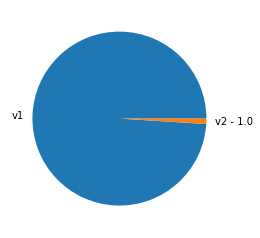

In [27]:
labels = ["v1", "v2 - %.1f" % percentage_v2]
sizes = [int(z) for z in [num_v1s, num_v2s]]
    
plt.pie(sizes, labels=labels)
plt.show()

## Check SEO Test Urls Exist on Production

In [28]:
urls_pass_seo_test = [] #
for url in seo_test_urls:
    html =page_cache.get_html(url, refresh_cache=True)
    if len(html)<2000:
        print("FAIL %s as page looks too small"%url)
    else:
        print("pass %s"%url)

pass https://blog.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/
pass https://blog.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/
pass https://blog.moneysmart.hk/zh-hk/travel/金巴-直通巴士-澳門船票-港珠澳大橋/
pass https://blog.moneysmart.hk/zh-hk/budgeting/迷你倉-價錢-收費-比較/
pass https://blog.moneysmart.hk/zh-hk/mortgage/綠置居-揀樓-麗翠苑-長沙灣-文件-入伙/
pass https://blog.moneysmart.hk/zh-hk/budgeting/返工-慳車費-九巴-港鐵-乘車-轉乘優惠-全月通-都會票/
pass https://blog.moneysmart.hk/zh-hk/budgeting/迪士尼-年票-奇妙處處通-優惠/
pass https://blog.moneysmart.hk/zh-hk/budgeting/小童免費-暑假-旅行-機鐵-機場快綫-優惠-klook-kkday/
pass https://blog.moneysmart.hk/zh-hk/budgeting/2018大學電腦優惠-時間表-poly-ou-city-港大-中大-科大/
pass https://blog.moneysmart.hk/zh-hk/credit-cards/恒生-信用卡-現金回贈-最划算/
pass https://blog.moneysmart.hk/zh-hk/mortgage/按揭-h按-p按-hibor-加息-銀行-封頂位/
pass https://blog.moneysmart.hk/zh-hk/mortgage/綠表白表資格-居屋-綠置居-入息-家庭-2019/
pass https://blog.moneysmart.hk/zh-hk/travel/行李費-日本-廉航-窮遊-攻略-寄艙-行李-限重/
pass https://blog.moneysmart.hk/zh-hk/budgetin

# Check SEO Test Articles v2 Loads (for before test is setup)

In [29]:
for url in seo_test_urls:
    if test_staging:
        url = make_staging_url(url)
    url = force_url_to_v2(url)
    print("Testing %s" % url)
    if not is_v2_page(url, page_cache):
        print("ERROR: %s isn't v2" %url)
        

Testing https://blog3.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/travel/金巴-直通巴士-澳門船票-港珠澳大橋/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/budgeting/迷你倉-價錢-收費-比較/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/mortgage/綠置居-揀樓-麗翠苑-長沙灣-文件-入伙/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/budgeting/返工-慳車費-九巴-港鐵-乘車-轉乘優惠-全月通-都會票/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/budgeting/迪士尼-年票-奇妙處處通-優惠/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/budgeting/小童免費-暑假-旅行-機鐵-機場快綫-優惠-klook-kkday/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/budgeting/2018大學電腦優惠-時間表-poly-ou-city-港大-中大-科大/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/credit-cards/恒生-信用卡-現金回贈-最划算/?forceTest=test
Testing https://blog3.moneysmart.hk/zh-hk/mortgage/按揭-h按-p按-hibor-加息-銀行-封

## Check SEO Test Articles are v2 (for once test is setup)

In [30]:
do_thoroughly = True # does a lot more page requests
repeat_per_url_times = 2
urls_pass_seo_test = [] #
for url in seo_test_urls:
    if test_staging:
        url = make_staging_url(url)
    passes = False
    try:
        if do_thoroughly:
            for a in range(repeat_per_url_times):
                page_cache.get_html(url, refresh_cache=True)
                is_v2 = is_v2_page(url,page_cache)
                if is_v2: 
                    passes=True
                    break
        else:
            passes = is_v2_page(url, page_cache)
    except Exception as e:
        print("%s is TOTAL FAIL with exception %s"%(url, str(e)))
    print("%s %s"%(url, ("pass" if passes else "FAIL")))
    urls_pass_seo_test.append(passes)
    
print("")
print("All pages pass: %s"%str(all(urls_pass_seo_test)))

https://blog.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/ FAIL
https://blog.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/ FAIL
https://blog.moneysmart.hk/zh-hk/travel/金巴-直通巴士-澳門船票-港珠澳大橋/ FAIL
https://blog.moneysmart.hk/zh-hk/budgeting/迷你倉-價錢-收費-比較/ FAIL
https://blog.moneysmart.hk/zh-hk/mortgage/綠置居-揀樓-麗翠苑-長沙灣-文件-入伙/ FAIL
https://blog.moneysmart.hk/zh-hk/budgeting/返工-慳車費-九巴-港鐵-乘車-轉乘優惠-全月通-都會票/ FAIL
https://blog.moneysmart.hk/zh-hk/budgeting/迪士尼-年票-奇妙處處通-優惠/ FAIL
https://blog.moneysmart.hk/zh-hk/budgeting/小童免費-暑假-旅行-機鐵-機場快綫-優惠-klook-kkday/ FAIL
https://blog.moneysmart.hk/zh-hk/budgeting/2018大學電腦優惠-時間表-poly-ou-city-港大-中大-科大/ FAIL
https://blog.moneysmart.hk/zh-hk/credit-cards/恒生-信用卡-現金回贈-最划算/ FAIL
https://blog.moneysmart.hk/zh-hk/mortgage/按揭-h按-p按-hibor-加息-銀行-封頂位/ FAIL
https://blog.moneysmart.hk/zh-hk/mortgage/綠表白表資格-居屋-綠置居-入息-家庭-2019/ FAIL
https://blog.moneysmart.hk/zh-hk/travel/行李費-日本-廉航-窮遊-攻略-寄艙-行李-限重/ FAIL
https://blog.moneysmart.hk/zh-hk/budgeting/202

In [31]:
len(non_seo_test_urls)

1383

In [32]:
# Lazy copy / paste with a bit of modification

print("Testing a set of urls that aren't in the SEO test point to v1 (at least sometimes)")
approx_num_test_urls = 3
non_seo_test_urls_to_test = [non_seo_test_urls[randint(0, len(non_seo_test_urls))] for z in range(approx_num_test_urls)]
non_seo_test_urls_to_test = non_seo_test_urls[:5] #TODO: REMOVE
do_thoroughly = True # does a lot more page requests
repeat_per_url_times = 2
urls_pass_seo_test = [] #
for url in non_seo_test_urls_to_test:
    if test_staging:
        url = make_staging_url(url)
    passes = False
    try:
        if do_thoroughly:
            for a in range(repeat_per_url_times):
                page_cache.get_html(url, refresh_cache=True)
                is_v1 = not(is_v2_page(url,page_cache))
                if is_v1: 
                    passes=True
                    break
        else:
            passes = not(is_v2_page(url, page_cache))
    except Exception as e:
        print("%s is TOTAL FAIL with exception %s"%(url, str(e)))
        #raise e
    print("%s %s"%(url, ("pass" if passes else "FAIL")))
    urls_pass_seo_test.append(passes)
    
print("")
print("All pages pass: %s"%str(all(urls_pass_seo_test)))

Testing a set of urls that aren't in the SEO test point to v1 (at least sometimes)
https://blog.moneysmart.hk/zh-hk/investment/%e9%96%8b%e6%a8%a1%e5%9e%8b%e8%88%96-%e9%ab%98%e9%81%94-%e6%a8%a1%e5%9e%8b-%e6%97%ba%e8%a7%92-%e5%b7%a5%e5%85%b7-%e5%ba%97/ pass
https://blog.moneysmart.hk/zh-hk/opinion/hktvmall-ztore-%e9%80%81%e8%b2%a8-%e6%ba%96%e6%99%82-%e6%8a%95%e8%b3%87/ pass
https://blog.moneysmart.hk/zh-hk/budgeting/%e9%8a%85%e9%91%bc%e7%81%a3-%e5%8f%89%e9%9b%9e%e9%a3%af-%e6%8a%b5%e9%a3%9f-%e6%af%94%e8%bc%83-%e8%a9%a6%e9%a3%9f-%e6%a3%8b%e5%93%a5-%e8%9b%87%e7%8e%8b%e4%ba%8c-%e5%a4%aa%e8%88%88-%e9%80%a3%e5%92%8c/ pass
https://blog.moneysmart.hk/zh-hk/budgeting/mustchill%e6%89%80%e5%80%bc-%e6%96%b0%e6%9c%b1%e5%8f%a4%e5%8a%9b%e9%9b%aa%e6%a2%9d-%e8%a9%a6%e9%a3%9f-baileys%e9%9b%aa%e6%a2%9d-%e9%bb%91%e7%89%9b%e9%9b%aa%e6%a2%9d-choco-bomb/ pass
https://blog.moneysmart.hk/zh-hk/budgeting/%e5%b9%b4%e5%ae%b5%e5%b8%82%e5%a0%b4-%e9%96%8b%e6%aa%94%e8%b3%ba%e9%8c%a2-5%e5%80%8b%e6%ba%96%e5%82%99-%e8%be%


## Check Test Articles have v2 AMP

In [33]:
if amp_is_enabled[country_to_test]:
    for url in seo_test_urls:

        if test_staging:
            url = make_staging_url(url)
        print("Testing %s"%url)
        amp_url = extract_link_to_amp_version(url, page_cache)
        if not amp_url:
            raise Exception()

        amp_url_is_valid = is_v2_amp_page(amp_url, page_cache)
        if not amp_url_is_valid:
            raise Exception()

        print("Looks good.")
else:
    print("Skipping test as country doesn't have AMP enabled.")

Skipping test as country doesn't have AMP enabled.


## Check Canonical Tags

In [34]:
force_canonical_check_to_v2 = True

In [35]:
# site_canonical_url = get_site_canonical_url()
# print("Checking canonical tags against %s"%site_canonical_url)
for url in seo_test_urls + non_seo_test_sample_urls:
    
    if test_staging:
        url = make_staging_url(url)
    #print("Testing %s "% url)
    
    if force_canonical_check_to_v2:
        url = force_url_to_v2(url)
    try:
        canonical_url = extract_canonical_tag(url, page_cache)
        print("%s \n\thas canonical %s"%(url, canonical_url))
        is_valid, error_message = canonical_tag_is_valid(url, canonical_url)
    except Exception as e:
        print("ERROR: failed to load %s with exception %s"%(url, e))
    
    if not is_valid: 
        #raise Exception()
        print("ERROR: "+ error_message+ "\n")
        
        

https://blog3.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/?forceTest=test 
	has canonical https://blog.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/
https://blog3.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/?forceTest=test 
	has canonical https://blog.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/
https://blog3.moneysmart.hk/zh-hk/travel/金巴-直通巴士-澳門船票-港珠澳大橋/?forceTest=test 
	has canonical https://blog.moneysmart.hk/zh-hk/travel/金巴-直通巴士-澳門船票-港珠澳大橋/
https://blog3.moneysmart.hk/zh-hk/budgeting/迷你倉-價錢-收費-比較/?forceTest=test 
	has canonical https://blog.moneysmart.hk/zh-hk/budgeting/迷你倉-價錢-收費-比較/
https://blog3.moneysmart.hk/zh-hk/mortgage/綠置居-揀樓-麗翠苑-長沙灣-文件-入伙/?forceTest=test 
	has canonical https://blog.moneysmart.hk/zh-hk/mortgage/綠置居-揀樓-麗翠苑-長沙灣-文件-入伙/
https://blog3.moneysmart.hk/zh-hk/budgeting/返工-慳車費-九巴-港鐵-乘車-轉乘優惠-全月通-都會票/?forceTest=test 
	has canonical https://blog.moneysmart.hk/zh-hk/budgeting/返工-慳車費-九巴-港鐵-乘車-轉乘優惠-全月通-都會票

## Check Test Articles and Non-Test Articles Have Sensible Structured Data

I.e.

* Use the canonical url
* Articles have 3 or 4 levels (home page, category, article) in the breadcrumbs
* BlogPosting at least exists

### Check BlogPosting Structured Data

In [36]:
for url in seo_test_urls+ non_seo_test_sample_urls:
    if test_staging:
        url = make_staging_url(url)
        
    url = force_url_to_v2(url)
    print()
    print("Testing %s"%url)
    try:
        is_good, error_message = check_blogposting_structured_data_looks_sensible(url, page_cache)
    except Exception as e:
        print("ERROR: %s failed with message %s" % (url, e))
    if not is_good:
        print("ERROR: "+ error_message)
        #raise Exception()


Testing https://blog3.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/?forceTest=test
getting meta description for https://blog3.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/?forceTest=test
ERROR: Expected the ID of the blogposting to be the canonical tag https://blog.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/, but got https://blog.moneysmart.hk/zh-hk/budgeting/%e8%a8%82%e4%bd%8dapp-eatigo-%e5%8d%8a%e5%83%b9-%e5%84%aa%e6%83%a0-%e8%a8%82%e4%bd%8d-book%e6%9e%b1/.  

Testing https://blog3.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/?forceTest=test
getting meta description for https://blog3.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/?forceTest=test
ERROR: Expected the ID of the blogposting to be the canonical tag https://blog.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/, but got https://blog.moneysmart.hk/zh-hk/budgeting/%e7%a5%9e%e6%b2%99%e8%bb%8a-%e7%a5%9e%e6%b2%99%e6%a9%9f-%e9%82%8a%e

### Check The Breadcrumbs

In [37]:
for url in seo_test_urls + non_seo_test_sample_urls:
    if test_staging:
        url = make_staging_url(url)
    url = force_url_to_v2(url)
    print()
    print("Testing %s"%url)
    is_good, error_message = check_breadcrumbs_are_sensible(url, page_cache)
    if not is_good:
        print("ERROR: "+ error_message)
        #raise Exception()


Testing https://blog3.moneysmart.hk/zh-hk/budgeting/訂位app-eatigo-半價-優惠-訂位-book枱/?forceTest=test
ERROR: Category breadcrumbs don't look like category pages ['https://blog.moneysmart.hk/budgeting/'].  

Testing https://blog3.moneysmart.hk/zh-hk/budgeting/神沙車-神沙機-邊區有-用表話你知-收銀車-heycoins-換幣龍/?forceTest=test
ERROR: Category breadcrumbs don't look like category pages ['https://blog.moneysmart.hk/budgeting/'].  

Testing https://blog3.moneysmart.hk/zh-hk/travel/金巴-直通巴士-澳門船票-港珠澳大橋/?forceTest=test
ERROR: Category breadcrumbs don't look like category pages ['https://blog.moneysmart.hk/travel/'].  

Testing https://blog3.moneysmart.hk/zh-hk/budgeting/迷你倉-價錢-收費-比較/?forceTest=test
ERROR: Category breadcrumbs don't look like category pages ['https://blog.moneysmart.hk/budgeting/'].  

Testing https://blog3.moneysmart.hk/zh-hk/mortgage/綠置居-揀樓-麗翠苑-長沙灣-文件-入伙/?forceTest=test
ERROR: Category breadcrumbs don't look like category pages ['https://blog.moneysmart.hk/mortgage/'].  

Testing https://blog3.mone

## Check Cloudflare is (to some extent) Working

In [54]:
# Check that v2 is cached
cache_test_article = non_seo_test_sample_urls[0]
if test_staging:
    cache_test_article = make_staging_url(cache_test_article)
cache_test_article = force_url_to_v2(cache_test_article)


for a in range(3):
    page_cache.get_html(cache_test_article, refresh_cache=True)
is_cached, cache_hit = page_cache.page_was_cdn_cached_and_hit(cache_test_article)
page_load_time = page_cache.page_response_time(cache_test_article)
print("Requested v2 url %s in"%(cache_test_article,))
print("Request took  %.3f"% (page_load_time,))
print("Cached (cloudflare runs) = %s"%is_cached)
print("Cache hit (actually cached) = %s"%cache_hit)

if not cache_hit or page_load_time>0.05:
    print("ERROR: doesn't look properly cached")

Requested v2 url https://blog3.moneysmart.hk/zh-hk/industrial-property/%e8%bb%8a%e4%bd%8d-%e6%8c%89%e6%8f%ad-%e8%b2%b7%e8%b3%a3-%e6%8a%95%e8%b3%87-%e5%8d%b0%e8%8a%b1%e7%a8%85-%e5%87%ba%e7%a7%9f/?forceTest=test in
Request took  0.045
Cached (cloudflare runs) = True
Cache hit (actually cached) = True


In [55]:
# TODO: >> this is giving too quick response somehow.

# Check v1 caching (if SG or HK, not expected to be cached)
cache_test_article = non_seo_test_sample_urls[0]
if test_staging:
    cache_test_article = make_staging_url(cache_test_article)
cache_test_article = force_url_to_v1(cache_test_article)


for a in range(3):
    page_cache.get_html(cache_test_article, refresh_cache=True)
is_cached, cache_hit = page_cache.page_was_cdn_cached_and_hit(cache_test_article)
page_load_time = page_cache.page_response_time(cache_test_article)

    
print("Requested v1 url %s in"%(cache_test_article,))
print("Request took  %.3f"% (page_load_time,))
print("Cached (cloudflare runs) = %s"%is_cached)
print("Cache hit (actually cached) = %s"%cache_hit)
print(country_to_test)
if country_to_test.lower() in ["sg", "hk"]:
    if cache_hit:
        print("ERROR, v1 shouldn't be cached")
    else:
        print("pass")
else:
    if not cache_hit:
        print("ERROR, v2 should be cached")
    elif page_load_time>0.05:
        print("ERROR, page load time was longer than expected for a cache hit")
    else:
        print("pass")
    

Requested v1 url https://blog.moneysmart.hk/zh-hk/industrial-property/%e8%bb%8a%e4%bd%8d-%e6%8c%89%e6%8f%ad-%e8%b2%b7%e8%b3%a3-%e6%8a%95%e8%b3%87-%e5%8d%b0%e8%8a%b1%e7%a8%85-%e5%87%ba%e7%a7%9f/?forceTest=control in
Request took  0.055
Cached (cloudflare runs) = True
Cache hit (actually cached) = False
hk
pass


## Check That Article Redirects are Working

In [40]:
#TODO: ideally check the redirect status, but not really sure how to do this nicely (it is in request.history)

In [41]:
redirects = load_redirects(country_to_test, for_staging = test_staging)

cow
Loading all of the redirects from ./Redirects/hk-production-redirects.csv
Skipping first line of url file: ['Origin', 'Target', 'Type', 'Format']
Loaded 3 redirects


In [42]:
test_only_sample_of_redirects = True

num_redirects_to_test_if_only_sample = 50

In [43]:
if test_only_sample_of_redirects:
    redirects_to_test = redirects[:num_redirects_to_test_if_only_sample] #better would be random sampling
else:
    redirects_to_test = redirects

### Redirects on v1

In [44]:
for from_url, to_url, status_code in redirects_to_test:
    from_url = force_url_to_v1(from_url)
    try:
        
        html = page_cache.get_html(from_url)
    except:
        html = ""
    if len(html)<2000:
        print("\nFAIL %s \n"% from_url)
    else:
        print("pass %s", from_url)

pass %s https://blog.moneysmart.hk/zh-hk/credit-cards/%E9%A3%9B%E8%A1%8C%E9%87%8C%E6%95%B8-%E4%BF%A1%E7%94%A8%E5%8D%A1-%E6%AF%94%E8%BC%83-2018/?forceTest=control
pass %s https://blog.moneysmart.hk/zh-hk/budgeting/%e5%98%89%e9%a0%93%e4%bb%80%e9%a4%85-%e6%8b%9c%e5%b9%b4-%e9%80%81%e7%a6%ae-%e8%be%b2%e6%9b%86%e6%96%b0%e5%b9%b4-%e7%b6%b2%e8%b3%bc-hktvmall/?forceTest=control
pass %s https://blog.moneysmart.hk/?forceTest=control


### Redirects on v2

In [45]:
#Simple test based on if the page loads and there's some sensible html length
#TODO: actually check destination page
for from_url, to_url, status_code in redirects_to_test:
    from_url = force_url_to_v2(from_url)
    try:
        
        html = page_cache.get_html(from_url)
    except:
        html = ""
    if len(html)<2000:
        print("\nFAIL %s \n"% from_url)
    else:
        print("pass %s"% from_url)

pass https://blog3.moneysmart.hk/zh-hk/credit-cards/%E9%A3%9B%E8%A1%8C%E9%87%8C%E6%95%B8-%E4%BF%A1%E7%94%A8%E5%8D%A1-%E6%AF%94%E8%BC%83-2018/?forceTest=test
pass https://blog3.moneysmart.hk/zh-hk/budgeting/%e5%98%89%e9%a0%93%e4%bb%80%e9%a4%85-%e6%8b%9c%e5%b9%b4-%e9%80%81%e7%a6%ae-%e8%be%b2%e6%9b%86%e6%96%b0%e5%b9%b4-%e7%b6%b2%e8%b3%bc-hktvmall/?forceTest=test
pass https://blog3.moneysmart.hk/?forceTest=test


# Check RSS Feeds

## Check the core RSS feed

In [46]:
core_rss_url = urllib.parse.urljoin(get_site_canonical_url(), "/feed/")
core_rss_body = page_cache.get_html(core_rss_url)
if "xml" in core_rss_body:
    print("Basic RSS feed looks good")
else:
    print("FAIL: RSS feed at %s doesn't look good"%core_rss_url)

Basic RSS feed looks good


In [56]:
#TODO: should really run these across more RSS feeds

if "www3" in core_rss_body:
    print("ERROR: www3 in rss feed")
    
if "blog3" in core_rss_body:
    print("ERROR: blog3 in rss feed")
    
if "admin." in core_rss_body or "blog-admin." in core_rss_body:
    print("ERROR: looks like an admin url in the rss feed somewhere.")
    
if "api." in core_rss_body:
    print("ERROR: looks like an API url in the rss feed somewhere.")
    


## Check the Full List of RSS feed (a lot of requests)

In [57]:
def load_rss_feed_urls_from_scalyr_logs(scalyr_log_file_path):
    """
    Expects a file as per the result of https://www.scalyr.com/events?filter=%22%2Ffeed%2F%22%20$status%3D200&teamToken=RsXhT5US%2FMZ7ugkOhT2g3g--&logSource=*blog-moneysmart-sg-*&showSystemPrefs=%5B%22timestamp%22%5D&showAdditionalFields=%5B%22uri%22,%22remote_ip%22,%22status%22%5D&startTime=7%20days&displayMode=%5Bobject%20Object%5D
    i.e. lines like:  00:18:12.000 uri='/comments/feed/' remote_ip='62.210.215.109' status=200
    
    Returns localised to staging / production
    """
    base_url = get_site_canonical_url()
    with open(scalyr_log_file_path) as f:
        lines = f.readlines()
        print("%i lines"%len(lines))
        urls = [z.split(" uri=")[1].split(" ")[0].strip("'") for z in lines]
        urls_filtered = [z for z in urls if "/feed/" in z]
    
    distinct_urls = list(set(urls_filtered))
    distinct_urls.sort()
    full_distinct_urls = [urllib.parse.urljoin(base_url, z) for z in distinct_urls]
    return full_distinct_urls

In [58]:
rss_log_urls = rss_feed_scalyr_requests_raw[country_to_test]
rss_urls = load_rss_feed_urls_from_scalyr_logs(rss_log_urls)
print("found %i RSS feed urls "% len(rss_urls))
print("e.g. (first 10):")
for a in rss_urls[:10]:
    print(a)

3182 lines
found 982 RSS feed urls 
e.g. (first 10):
https://blog.moneysmart.hk/credit-cards/%E4%BA%A4%E6%B0%B4%E9%9B%BB%E7%85%A4-%E9%9B%9C%E8%B2%BB-%E4%BF%A1%E7%94%A8%E5%8D%A1%E6%AF%94%E8%BC%83/feed/
https://blog.moneysmart.hk/credit-cards/%E9%A3%9B%E8%A1%8C%E9%87%8C%E6%95%B8-%E4%BF%A1%E7%94%A8%E5%8D%A1-%E6%AF%94%E8%BC%83-2018/feed/
https://blog.moneysmart.hk/credit-cards/best-asia-miles-cards-in-hong-kong/feed/
https://blog.moneysmart.hk/credit-cards/best-supermarket-cards-offers-in-hong-kong/feed/
https://blog.moneysmart.hk/en/%E4%BF%A1%E8%B2%B8%E8%A9%95%E5%88%86/feed/
https://blog.moneysmart.hk/en/%e4%bf%a1%e8%b2%b8%e8%a9%95%e5%88%86/feed/
https://blog.moneysmart.hk/en/%e6%97%85%e8%a1%8c/feed/
https://blog.moneysmart.hk/en/%e6%97%a5%e6%9c%ac/feed/
https://blog.moneysmart.hk/en/%e9%96%8b%e6%94%af/feed/
https://blog.moneysmart.hk/en/air-miles/feed/


In [59]:
passing_rss_feeds = []
failing_rss_feeds = []

In [60]:
num_rss_urls_to_check = 200 # put -1 for all 

print("Checking the first %i of the rss feed urls"%num_rss_urls_to_check)
num_rss_urls = len(rss_urls)
for i, rss_url in enumerate(rss_urls[:num_rss_urls_to_check]):
    if i<10:
        print("checking %i %s"%(i, rss_url))
    if i%10==0:
        print("Checking %i / %i"%(i, num_rss_urls))
    try:
        rss_text = page_cache.get_html(rss_url)
        if "xml" in rss_text:
            passing_rss_feeds.append(rss_url)
        else:
            failing_rss_feeds.append(rss_url)
    except:
        failing_rss_feeds.append(rss_url)
        
print("Got %i passing and %i failing RSS feeds"%(len(passing_rss_feeds), len(failing_rss_feeds)))

Checking the first 200 of the rss feed urls
checking 0 https://blog.moneysmart.hk/credit-cards/%E4%BA%A4%E6%B0%B4%E9%9B%BB%E7%85%A4-%E9%9B%9C%E8%B2%BB-%E4%BF%A1%E7%94%A8%E5%8D%A1%E6%AF%94%E8%BC%83/feed/
Checking 0 / 982
checking 1 https://blog.moneysmart.hk/credit-cards/%E9%A3%9B%E8%A1%8C%E9%87%8C%E6%95%B8-%E4%BF%A1%E7%94%A8%E5%8D%A1-%E6%AF%94%E8%BC%83-2018/feed/
checking 2 https://blog.moneysmart.hk/credit-cards/best-asia-miles-cards-in-hong-kong/feed/
checking 3 https://blog.moneysmart.hk/credit-cards/best-supermarket-cards-offers-in-hong-kong/feed/
checking 4 https://blog.moneysmart.hk/en/%E4%BF%A1%E8%B2%B8%E8%A9%95%E5%88%86/feed/
checking 5 https://blog.moneysmart.hk/en/%e4%bf%a1%e8%b2%b8%e8%a9%95%e5%88%86/feed/
checking 6 https://blog.moneysmart.hk/en/%e6%97%85%e8%a1%8c/feed/
checking 7 https://blog.moneysmart.hk/en/%e6%97%a5%e6%9c%ac/feed/
checking 8 https://blog.moneysmart.hk/en/%e9%96%8b%e6%94%af/feed/
checking 9 https://blog.moneysmart.hk/en/air-miles/feed/
Checking 10 / 982
C

In [61]:
if len(failing_rss_feeds)>0:
    failing_rss_feeds_to_focus = [z for z in failing_rss_feeds if urllib.parse.urlsplit(z).path.startswith("/feed")]
    print("First 20 urls to focus on:")
    for a in failing_rss_feeds_to_focus[:20]:
        print(a)
    print("")
    print("First 20 failing rss urls overall:")
    for a in failing_rss_feeds[:20]:
        print(a)